# 04 - Supervised Learning & Model Training
## Heart Disease UCI Dataset

### Objectives:
- Train multiple classification models on selected features
- Evaluate models using comprehensive metrics
- Compare model performance and select best performers
- Generate ROC curves and confusion matrices
- Prepare models for hyperparameter tuning

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Processed Data

In [2]:
def load_training_data():
    """Load training and testing data with fallback mechanisms"""
    try:
        # Try to load feature-selected data first
        X_train = pd.read_csv('../data/X_train_selected.csv')
        X_test = pd.read_csv('../data/X_test_selected.csv')
        print(" Loaded feature-selected data")
        
    except FileNotFoundError:
        try:
            # Fallback to PCA data
            X_train = pd.read_csv('../data/X_train_pca.csv')
            X_test = pd.read_csv('../data/X_test_pca.csv')
            print(" Loaded PCA-transformed data")
            
        except FileNotFoundError:
            # Fallback to original preprocessed data
            X_train = pd.read_csv('../data/X_train.csv')
            X_test = pd.read_csv('../data/X_test.csv')
            print(" Loaded original preprocessed data")
    
    # Load target variables
    y_train = pd.read_csv('../data/y_train.csv').squeeze()
    y_test = pd.read_csv('../data/y_test.csv').squeeze()
    
    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, y_train, y_test = load_training_data()

print(f"\n Dataset Summary:")
print(f"   Training set: {X_train.shape}")
print(f"   Testing set: {X_test.shape}")
print(f"   Features: {list(X_train.columns)}")
print(f"   Target classes: {sorted(y_train.unique())}")

# Display class distribution
print(f"\n Target Distribution:")
target_counts = y_train.value_counts().sort_index()
for target_val, count in target_counts.items():
    severity = ['No Disease', 'Mild', 'Moderate', 'Serious', 'Severe'][target_val]
    print(f"   {target_val} - {severity:10}: {count:3d} samples ({count/len(y_train)*100:.1f}%)")

 Loaded feature-selected data

 Dataset Summary:
   Training set: (736, 8)
   Testing set: (184, 8)
   Features: ['cp', 'thalach', 'exang', 'oldpeak', 'chol', 'thal', 'age', 'sex']
   Target classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

 Target Distribution:
   0 - No Disease: 329 samples (44.7%)
   1 - Mild      : 212 samples (28.8%)
   2 - Moderate  :  87 samples (11.8%)
   3 - Serious   :  86 samples (11.7%)
   4 - Severe    :  22 samples (3.0%)


## 3. Initialize Classification Models

In [3]:
print("=== INITIALIZING CLASSIFICATION MODELS ===\n")

# Define models with basic parameters
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        multi_class='multinomial'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        max_depth=10
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'Support Vector Machine': SVC(
        random_state=42,
        probability=True,  # Enable for ROC curves
        kernel='rbf'
    )
}

print("Models to be trained:")
for name, model in models.items():
    print(f"    {name}")

# Dictionary to store trained models and results
trained_models = {}
model_results = {}

=== INITIALIZING CLASSIFICATION MODELS ===

Models to be trained:
    Logistic Regression
    Decision Tree
    Random Forest
    Support Vector Machine


## 4. Train and Evaluate Models

In [4]:
print("=== MODEL TRAINING & EVALUATION ===\n")

for name, model in models.items():
    print(f"🚀 Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Calculate ROC AUC (for multi-class)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    else:
        roc_auc = 0.0
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    trained_models[name] = model
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"    Training completed")
    print(f"    Test Accuracy: {accuracy:.4f}")
    print(f"    CV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    print(f"    ROC AUC: {roc_auc:.4f}")
    print()

=== MODEL TRAINING & EVALUATION ===

🚀 Training Logistic Regression...
    Training completed
    Test Accuracy: 0.5707
    CV Accuracy: 0.5611 ± 0.0330
    F1-Score: 0.5429
    ROC AUC: 0.8137

🚀 Training Decision Tree...
    Training completed
    Test Accuracy: 0.5109
    CV Accuracy: 0.5041 ± 0.0150
    F1-Score: 0.5014
    ROC AUC: 0.6589

🚀 Training Random Forest...
    Training completed
    Test Accuracy: 0.5815
    CV Accuracy: 0.5530 ± 0.0161
    F1-Score: 0.5691
    ROC AUC: 0.8127

🚀 Training Support Vector Machine...
    Training completed
    Test Accuracy: 0.5924
    CV Accuracy: 0.5639 ± 0.0302
    F1-Score: 0.5423
    ROC AUC: 0.8262



## 5. Comprehensive Model Comparison

In [5]:
print("=== MODEL PERFORMANCE COMPARISON ===\n")

# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
results_df = results_df.sort_values('f1_score', ascending=False)

print("Model Performance Metrics:")
print("-" * 90)
print(f"{'Model':20} | {'Accuracy':8} | {'Precision':8} | {'Recall':8} | {'F1-Score':8} | {'ROC AUC':8} | {'CV Acc':8}")
print("-" * 90)
for model_name, metrics in results_df.iterrows():
    print(f"{model_name:20} | {metrics['accuracy']:8.4f} | {metrics['precision']:8.4f} | {metrics['recall']:8.4f} | "
          f"{metrics['f1_score']:8.4f} | {metrics['roc_auc']:8.4f} | {metrics['cv_mean']:8.4f}")

# Identify best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   ROC AUC: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

=== MODEL PERFORMANCE COMPARISON ===

Model Performance Metrics:
------------------------------------------------------------------------------------------
Model                | Accuracy | Precision | Recall   | F1-Score | ROC AUC  | CV Acc  
------------------------------------------------------------------------------------------
Random Forest        |   0.5815 |   0.5661 |   0.5815 |   0.5691 |   0.8127 |   0.5530
Logistic Regression  |   0.5707 |   0.5548 |   0.5707 |   0.5429 |   0.8137 |   0.5611
Support Vector Machine |   0.5924 |   0.5213 |   0.5924 |   0.5423 |   0.8262 |   0.5639
Decision Tree        |   0.5109 |   0.4975 |   0.5109 |   0.5014 |   0.6589 |   0.5041

 BEST PERFORMING MODEL: Random Forest
   F1-Score: 0.5691
   Accuracy: 0.5815
   ROC AUC: 0.8127


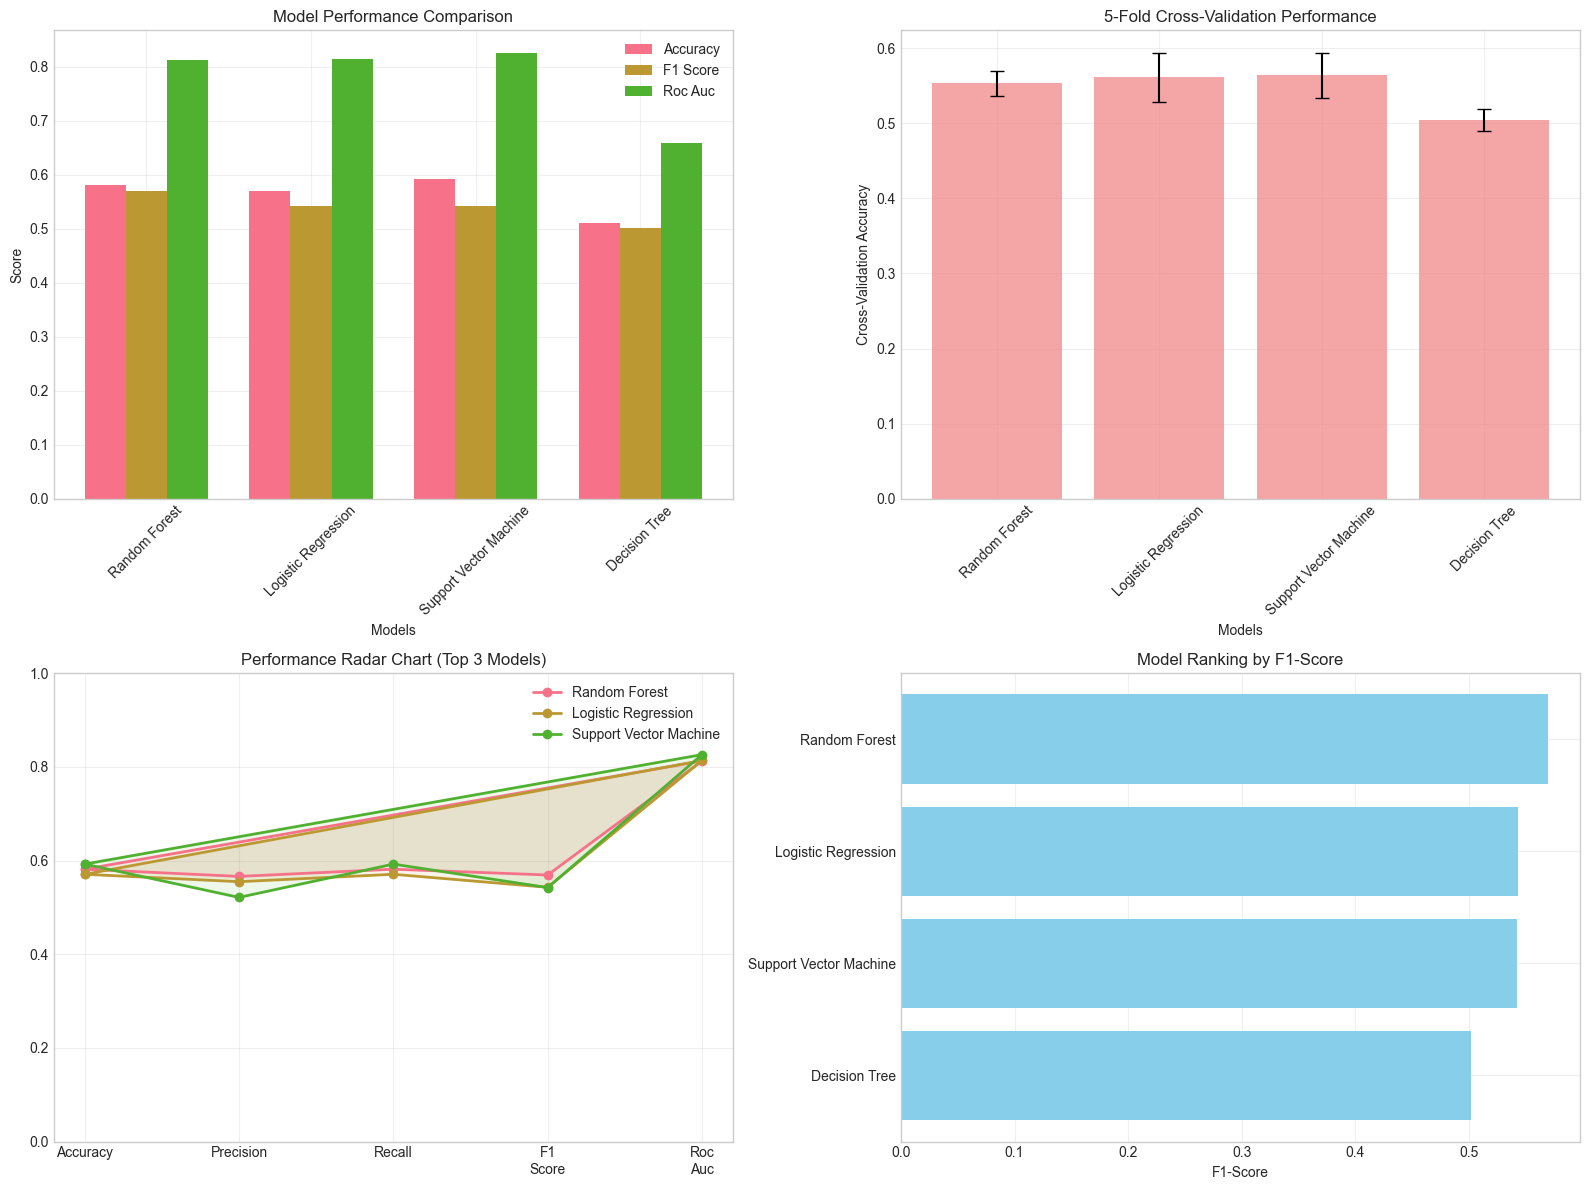

In [6]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy and F1-Score comparison
metrics_to_plot = ['accuracy', 'f1_score', 'roc_auc']
x_pos = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    axes[0, 0].bar(x_pos + i*width, [model_results[model][metric] for model in results_df.index], 
                   width, label=metric.replace('_', ' ').title())

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x_pos + width)
axes[0, 0].set_xticklabels(results_df.index, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cross-validation scores
cv_means = [model_results[model]['cv_mean'] for model in results_df.index]
cv_stds = [model_results[model]['cv_std'] for model in results_df.index]

axes[0, 1].bar(results_df.index, cv_means, yerr=cv_stds, capsize=5, alpha=0.7, color='lightcoral')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Cross-Validation Accuracy')
axes[0, 1].set_title('5-Fold Cross-Validation Performance')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Detailed metrics radar chart (simplified)
metrics_radar = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for i, model_name in enumerate(results_df.index[:3]):  # Top 3 models
    values = [model_results[model_name][metric] for metric in metrics_radar]
    values += values[:1]  # Complete the circle
    axes[1, 0].plot(angles, values, 'o-', linewidth=2, label=model_name)
    axes[1, 0].fill(angles, values, alpha=0.1)

axes[1, 0].set_xticks(angles[:-1])
axes[1, 0].set_xticklabels([m.replace('_', '\n').title() for m in metrics_radar])
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_title('Performance Radar Chart (Top 3 Models)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model ranking
ranking_scores = results_df['f1_score'].sort_values(ascending=True)
axes[1, 1].barh(range(len(ranking_scores)), ranking_scores.values, color='skyblue')
axes[1, 1].set_yticks(range(len(ranking_scores)))
axes[1, 1].set_yticklabels(ranking_scores.index)
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('Model Ranking by F1-Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Detailed Model Analysis

=== DETAILED MODEL ANALYSIS ===


 Random Forest - Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.77      0.80      0.79        82
        Mild       0.48      0.57      0.52        53
    Moderate       0.33      0.27      0.30        22
     Serious       0.25      0.19      0.22        21
      Severe       0.50      0.17      0.25         6

    accuracy                           0.58       184
   macro avg       0.47      0.40      0.41       184
weighted avg       0.57      0.58      0.57       184


 Logistic Regression - Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.74      0.85      0.80        82
        Mild       0.46      0.53      0.49        53
    Moderate       0.60      0.14      0.22        22
     Serious       0.17      0.19      0.18        

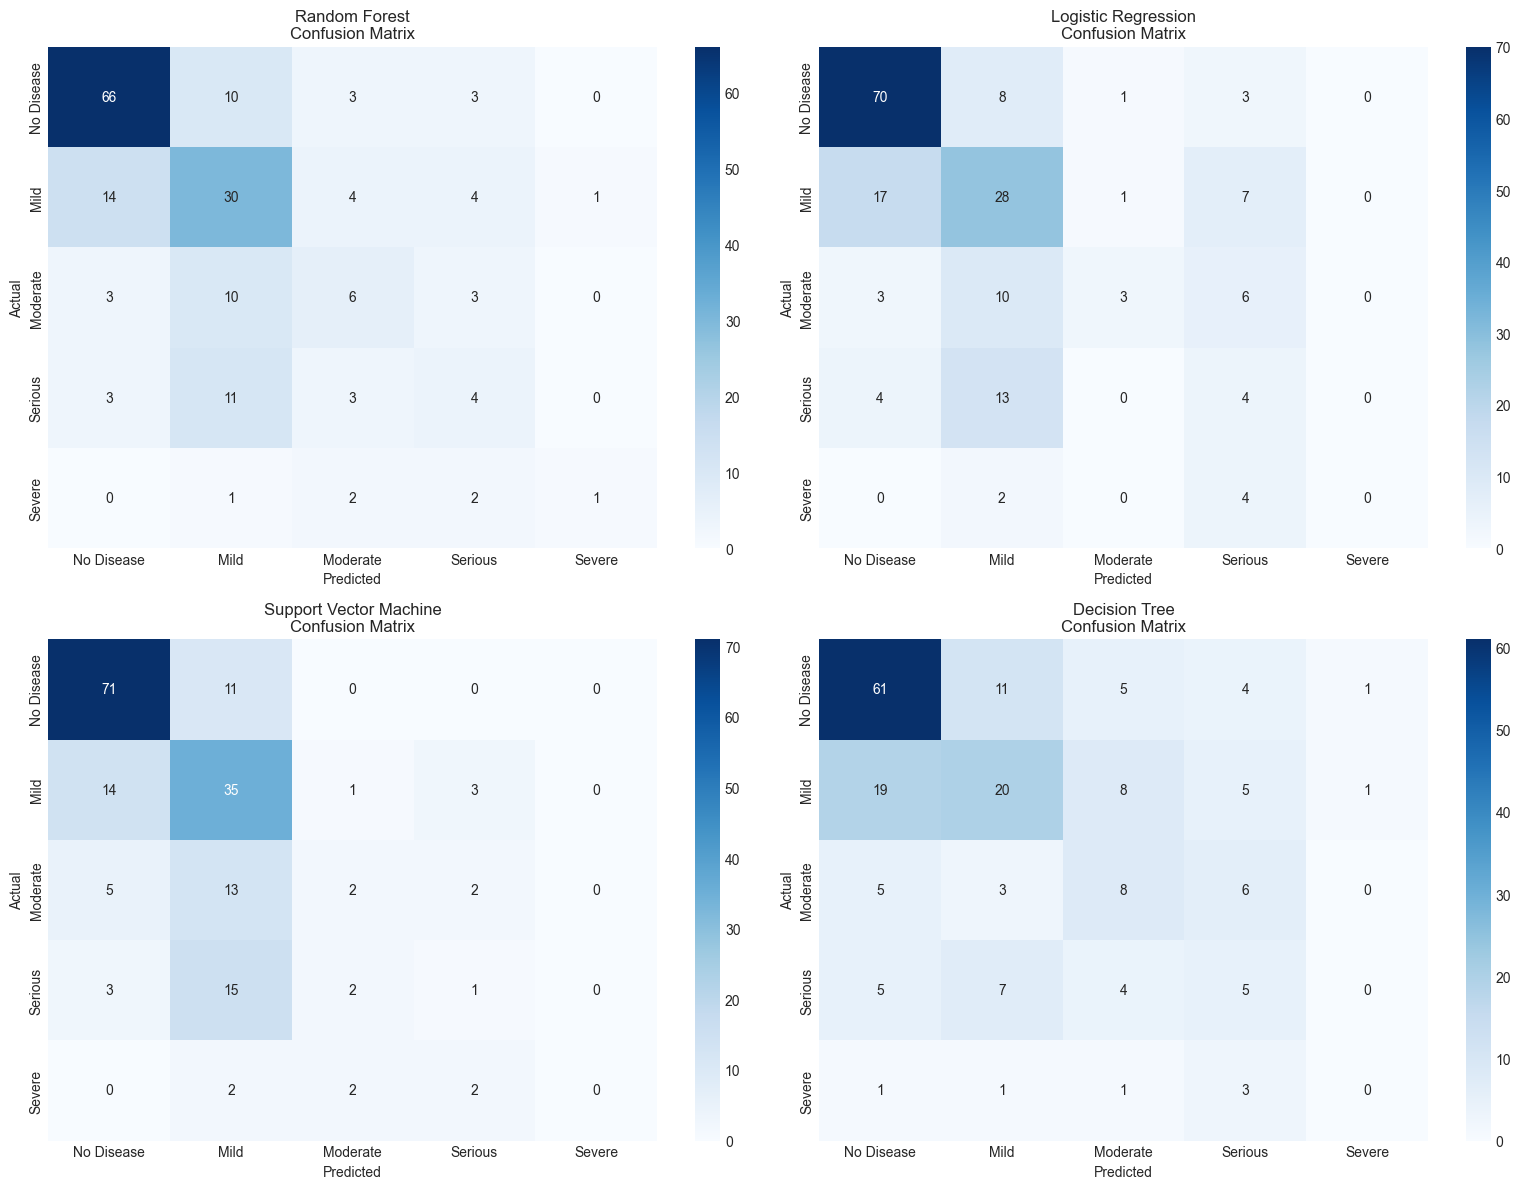

In [7]:
print("=== DETAILED MODEL ANALYSIS ===\n")

# Generate detailed classification reports for each model
for model_name in results_df.index:
    print(f"\n {model_name} - Classification Report:")
    print("-" * 60)
    y_pred = model_results[model_name]['predictions']
    print(classification_report(y_test, y_pred, 
                               target_names=['No Disease', 'Mild', 'Moderate', 'Serious', 'Severe']))

# Generate confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

class_names = ['No Disease', 'Mild', 'Moderate', 'Serious', 'Severe']

for i, model_name in enumerate(results_df.index):
    y_pred = model_results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'{model_name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

=== ROC CURVES ANALYSIS ===



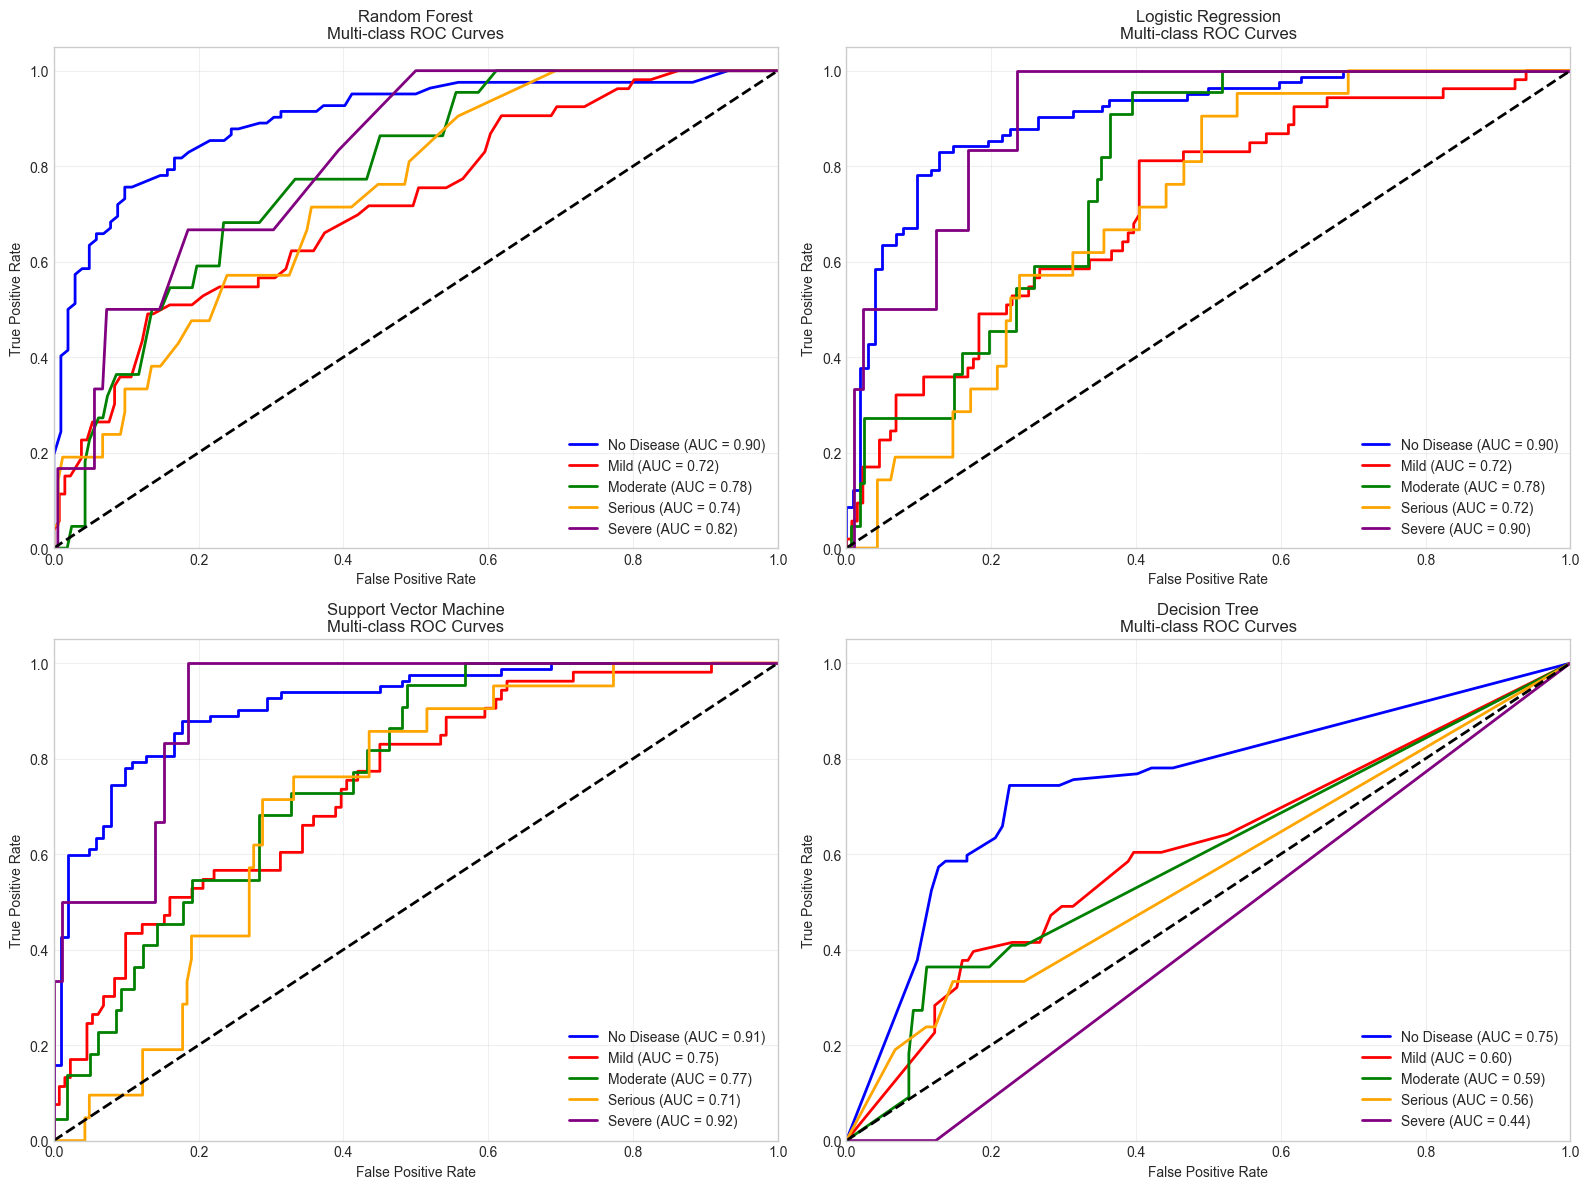

In [8]:
# ROC Curves for multi-class classification
print("=== ROC CURVES ANALYSIS ===\n")

# Binarize the output for ROC curves
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, model_name in enumerate(results_df.index):
    if model_results[model_name]['probabilities'] is not None:
        y_score = model_results[model_name]['probabilities']
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
            roc_auc[j] = roc_auc_score(y_test_bin[:, j], y_score[:, j])
        
        # Plot all ROC curves
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for j, color in zip(range(n_classes), colors):
            axes[i].plot(fpr[j], tpr[j], color=color, lw=2,
                       label='{0} (AUC = {1:0.2f})'.format(class_names[j], roc_auc[j]))
        
        axes[i].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'{model_name}\nMulti-class ROC Curves')
        axes[i].legend(loc="lower right")
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis (for tree-based models)

=== FEATURE IMPORTANCE ANALYSIS ===


 Decision Tree - Top 5 Features:
   cp             : 0.1674
   oldpeak        : 0.1751
   chol           : 0.1815
   age            : 0.1857
   thalach        : 0.2089

 Random Forest - Top 5 Features:
   cp             : 0.0976
   oldpeak        : 0.1595
   chol           : 0.1906
   thalach        : 0.2025
   age            : 0.2069


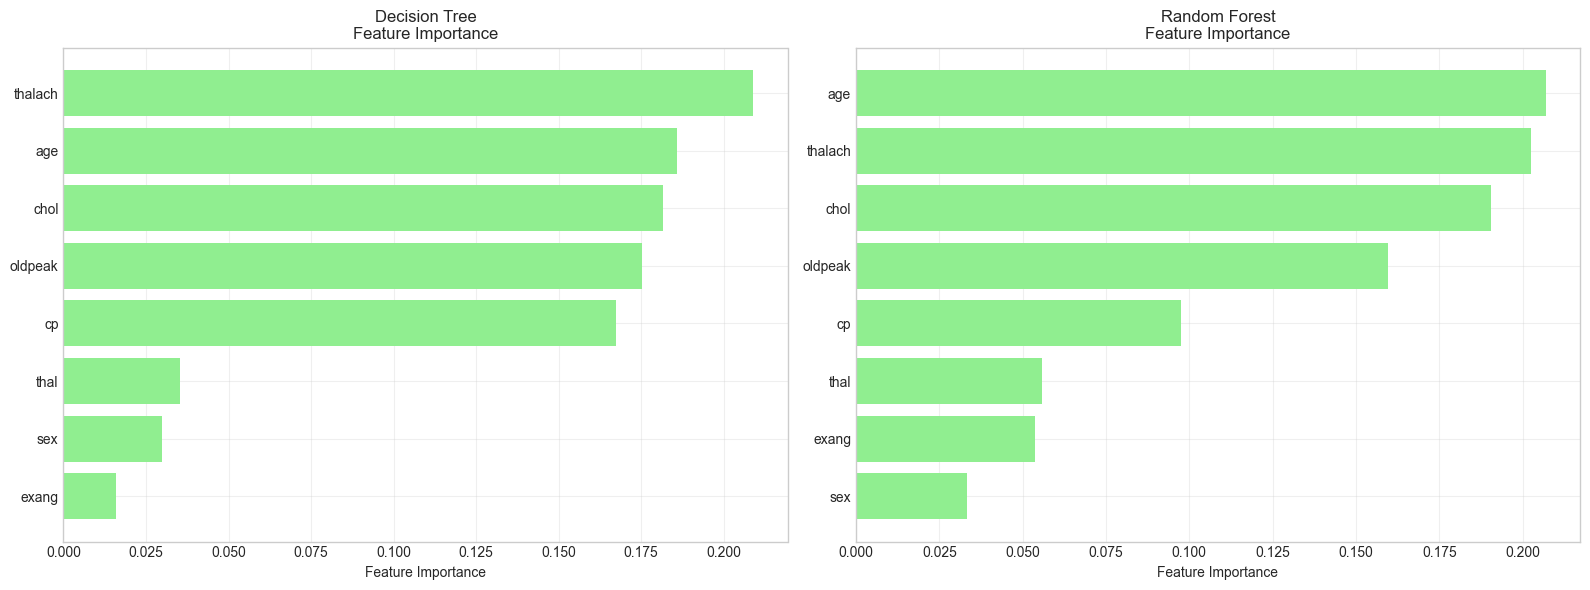

In [9]:
print("=== FEATURE IMPORTANCE ANALYSIS ===\n")

# Analyze feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, model_name in enumerate(tree_models):
    if model_name in trained_models and hasattr(trained_models[model_name], 'feature_importances_'):
        importances = trained_models[model_name].feature_importances_
        feature_names = X_train.columns
        
        # Create feature importance DataFrame
        feat_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True)
        
        # Plot
        axes[i].barh(range(len(feat_imp_df)), feat_imp_df['importance'], color='lightgreen')
        axes[i].set_yticks(range(len(feat_imp_df)))
        axes[i].set_yticklabels(feat_imp_df['feature'])
        axes[i].set_xlabel('Feature Importance')
        axes[i].set_title(f'{model_name}\nFeature Importance')
        axes[i].grid(True, alpha=0.3)
        
        print(f"\n {model_name} - Top 5 Features:")
        top_features = feat_imp_df.tail(5)
        for _, row in top_features.iterrows():
            print(f"   {row['feature']:15}: {row['importance']:.4f}")

plt.tight_layout()
plt.show()

## 8. Save Models and Results

In [10]:
print("=== SAVING MODELS & RESULTS ===\n")

# Save all trained models
for model_name, model in trained_models.items():
    filename = f'../models/{model_name.lower().replace(" ", "_")}_model.pkl'
    joblib.dump(model, filename)
    print(f" Saved {model_name}: {filename}")

# Save the best model separately
best_model_filename = f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, best_model_filename)
print(f"\n Saved Best Model: {best_model_filename}")

# Save performance results
results_df.to_csv('../results/model_performance_comparison.csv')

# Save detailed predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    **{f'{name}_pred': model_results[name]['predictions'] for name in model_results}
})
predictions_df.to_csv('../results/model_predictions.csv', index=False)

# Save comprehensive evaluation report
with open('../results/model_evaluation_summary.txt', 'w') as f:
    f.write("HEART DISEASE CLASSIFICATION - MODEL EVALUATION SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Best F1-Score: {results_df.loc[best_model_name, 'f1_score']:.4f}\n")
    f.write(f"Best Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}\n\n")
    
    f.write("ALL MODELS PERFORMANCE:\n")
    f.write("-" * 60 + "\n")
    for model_name in results_df.index:
        f.write(f"{model_name:20}: F1={model_results[model_name]['f1_score']:.4f}, "
               f"Acc={model_results[model_name]['accuracy']:.4f}, "
               f"AUC={model_results[model_name]['roc_auc']:.4f}\n")

print("\n All models and results saved successfully!")
print(f" Performance summary saved: ../results/model_evaluation_summary.txt")

print(f"\n🎉 Supervised Learning completed! Ready for hyperparameter tuning.")

=== SAVING MODELS & RESULTS ===

 Saved Logistic Regression: ../models/logistic_regression_model.pkl
 Saved Decision Tree: ../models/decision_tree_model.pkl
 Saved Random Forest: ../models/random_forest_model.pkl
 Saved Support Vector Machine: ../models/support_vector_machine_model.pkl

 Saved Best Model: ../models/best_model_random_forest.pkl

 All models and results saved successfully!
 Performance summary saved: ../results/model_evaluation_summary.txt

🎉 Supervised Learning completed! Ready for hyperparameter tuning.
